In [1]:
import pandas as pd
import requests
import codecs
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
chrome_driver_path = "/Users/yuri/NBA_Project/"
os.environ["PATH"] += os.pathsep + chrome_driver_path

Загружаем html страницы с со всеми результатами сезонов NBA начиная с 2010-2011г. с помощью selenium

In [3]:
main_url = 'https://www.flashscore.co.uk/basketball/usa/nba'

seasons = []
for year in range (2010, 2024):
    seasons.append(('-{}-{}').format(year, year+1))

driver = webdriver.Chrome()
driver.delete_all_cookies()
driver.get(main_url)

# Нажимаем кнопку "Reject All"
reject_all_button = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, "onetrust-reject-all-handler")))
if reject_all_button:
    reject_all_button.click()

for season in seasons:
    season_url = main_url + str(season)
    driver.get(season_url)
    # Нажимаем кнопку "Show more matches" многократно
    while True:
        try:
            show_more_button = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.LINK_TEXT, "Show more matches")))
            show_more_button.click()
            show_more_button = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.LINK_TEXT, "Show more matches")))
        except:
            break
  
    page_content = driver.page_source
    soup = BeautifulSoup(page_content, 'html.parser')
    with codecs.open('htmls/nba'+str(season)+'.html', 'w+', encoding='utf-8') as f:
        f.write(soup.prettify())    
driver.quit()

Создаем датафреймы из файлов html с нужными столбцами: date, home team, away team, total scores, scores
by halves (количество очков за первую и вторую половину у домашней и гостевой команды), в колонке 'result' как 1 будут отмечены результативные игры, 0 - не результативные. 

In [4]:
def make_df(page, year):

    soup = BeautifulSoup(page, 'html.parser')
    classes = ['event__participant', 'event__time', 'event__part', 'event__score']
    elements = soup.find_all(class_=classes)

    df = pd.DataFrame()

    for i in range(len(elements)):
        if (':') in str(elements[i].get_text(strip=True)):
            try:
                last = len(df)
                df.loc[last, 'date'] = elements[i].get_text(strip=True)
                df.loc[last, 'home_team'] = elements[i+1].get_text(strip=True)
                df.loc[last, 'away_team'] = elements[i+2].get_text(strip=True)
                df.loc[last, 'home_score'] = int(elements[i+3].get_text(strip=True))
                df.loc[last, 'away_score'] = int(elements[i+4].get_text(strip=True))
                df.loc[last, 'home_team_1st_half'] = int(elements[i+5].get_text(strip=True)) + int(elements[i+7].get_text(strip=True))
                df.loc[last, 'away_team_1st_half'] = int(elements[i+6].get_text(strip=True)) + int(elements[i+8].get_text(strip=True))
                df.loc[last, 'home_team_2nd_half'] = int(elements[i+9].get_text(strip=True)) + int(elements[i+11].get_text(strip=True))
                df.loc[last, 'away_team_2nd_half'] = int(elements[i+10].get_text(strip=True)) + int(elements[i+12].get_text(strip=True))
            except:
                continue
                
    df['result'] = 0
    df.loc[(df['home_team_1st_half'] > df['away_team_1st_half']) & 
                ((df['home_team_1st_half'] + df['home_team_2nd_half']) < 
                 (df['away_team_1st_half'] + df['away_team_2nd_half'])), 'result'] = 1

    df.loc[(df['home_team_1st_half'] < df['away_team_1st_half']) & 
                ((df['home_team_1st_half'] + df['home_team_2nd_half']) > 
                 (df['away_team_1st_half'] + df['away_team_2nd_half'])), 'result'] = 1

    df['date'] = df['date'].str.replace('AOT', '')
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x + '.{}'.format(year+1), format='%d.%m. %H:%M.%Y') \
    if int(x.split('.')[1]) in range(1, 8) else pd.to_datetime(x + '.{}'.format(year), format='%d.%m. %H:%M.%Y'))
    df['date'] = df['date'].dt.date
    df['date'] = pd.to_datetime(df['date'])
    
    return df

Не включаем 2 сезона с пандемией поскольку матчи проводились в других условиях.

In [11]:
dfs = []
for year_range in [(2010, 2019), (2021, 2024)]: # not inlude pandemia seasons
    for year in range(year_range[0], year_range[1]):
        with open('htmls/nba-{}-{}.html'.format(year, year+1)) as f:
            page = f.read()
        df = make_df(page, year)
        dfs.append(df)  

In [12]:
dfs[0].head()

,date,home_team,away_team,home_score,away_score,home_team_1st_half,away_team_1st_half,home_team_2nd_half,away_team_2nd_half,result
0,2011-06-13,Miami Heat,Dallas Mavericks,95.0,105.0,51.0,53.0,44.0,52.0,0
1,2011-06-10,Dallas Mavericks,Miami Heat,112.0,103.0,60.0,57.0,52.0,46.0,0
2,2011-06-08,Dallas Mavericks,Miami Heat,86.0,83.0,45.0,47.0,41.0,36.0,1
3,2011-06-06,Dallas Mavericks,Miami Heat,86.0,88.0,42.0,47.0,44.0,41.0,0
4,2011-06-03,Miami Heat,Dallas Mavericks,93.0,95.0,51.0,51.0,42.0,44.0,0


Выведем на график общее количество результативных игр по датам - синяя линия, и сравним с оранжевой линией, которая обозначает 25-процентное соотношение результатитивных игр к общему количеству игр по дням. То есть если синяя линия располагается выше, то общее количествр результативных игр на данную дату больше 25%, если ниже - меньше.
По графикам можно увидеть что по некоторым сезонам линии идут совсем рядом, также присутствует тенденция, что в начале сезона синяя линия идет примерно в ровень с оранжевой до какого-то момента, затем уходит вниз.

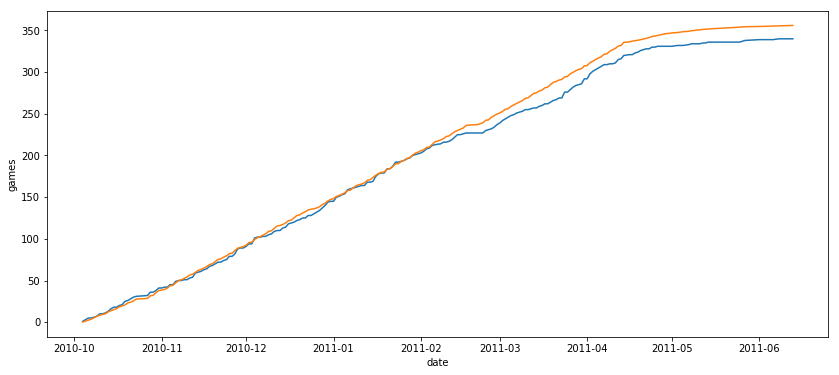

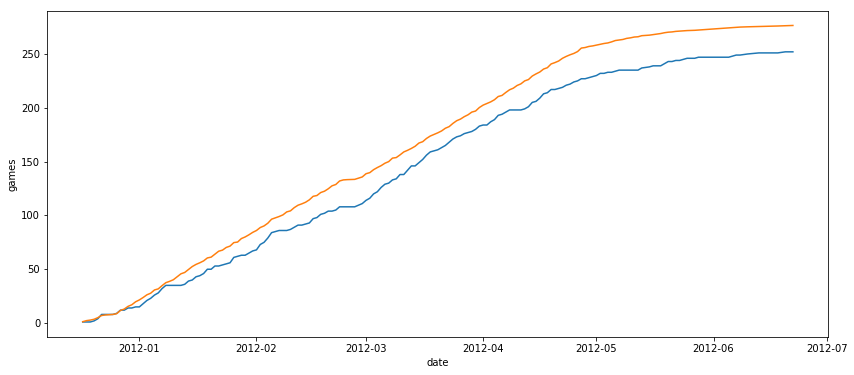

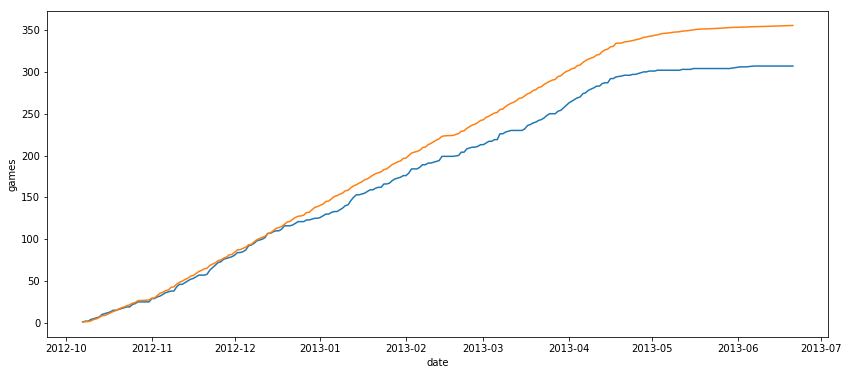

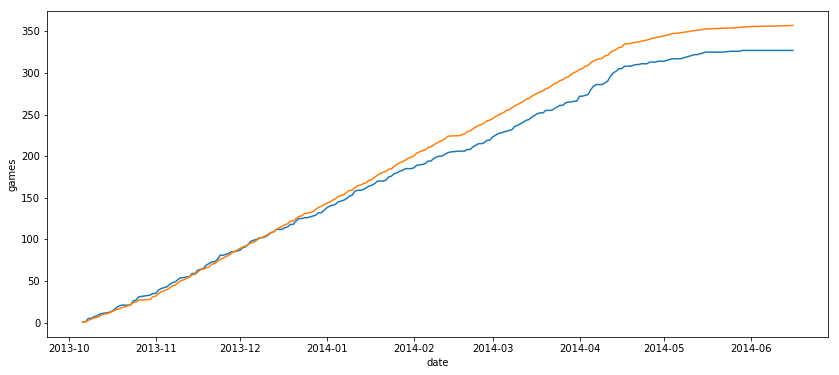

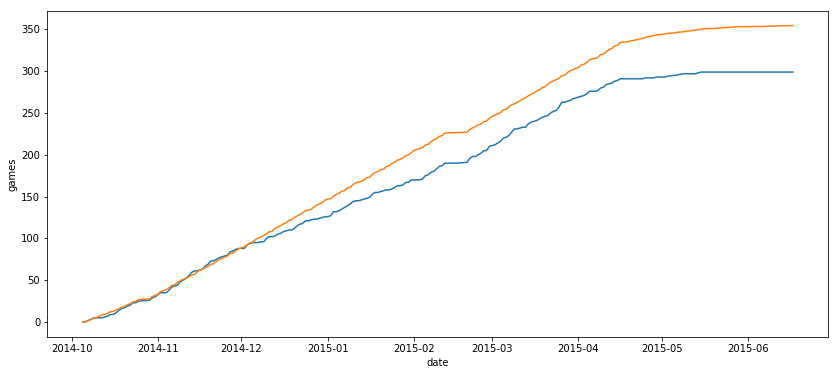

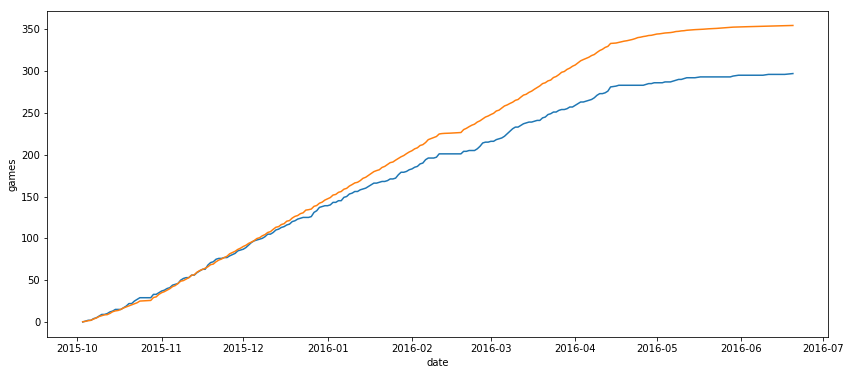

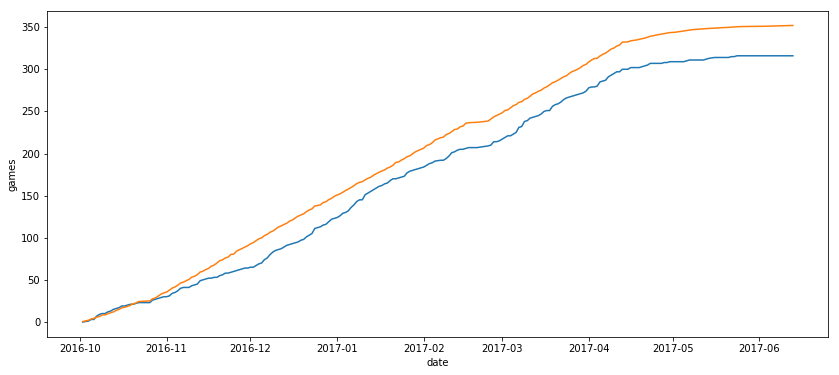

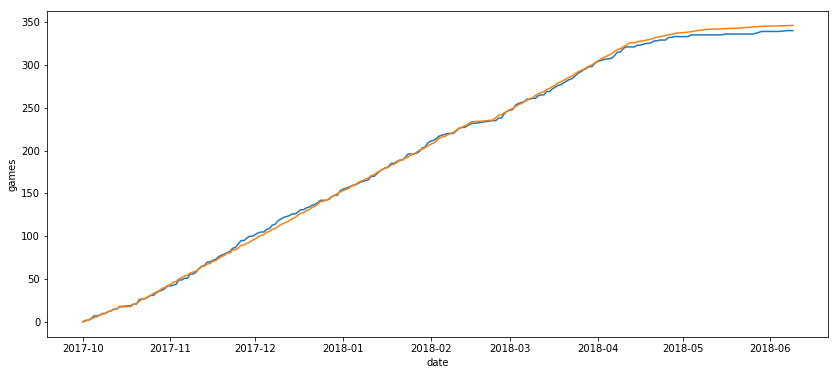

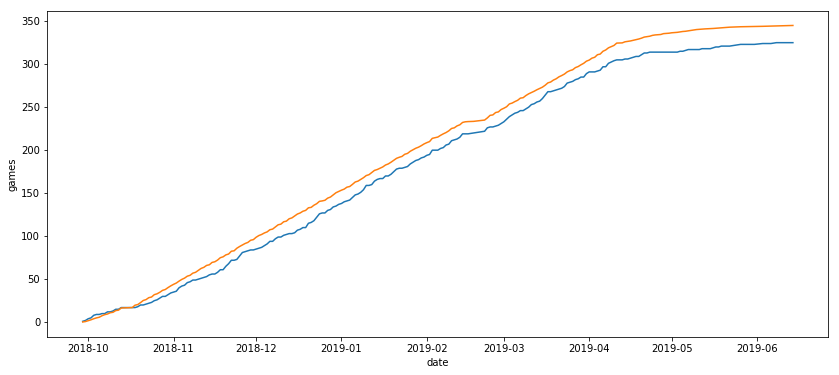

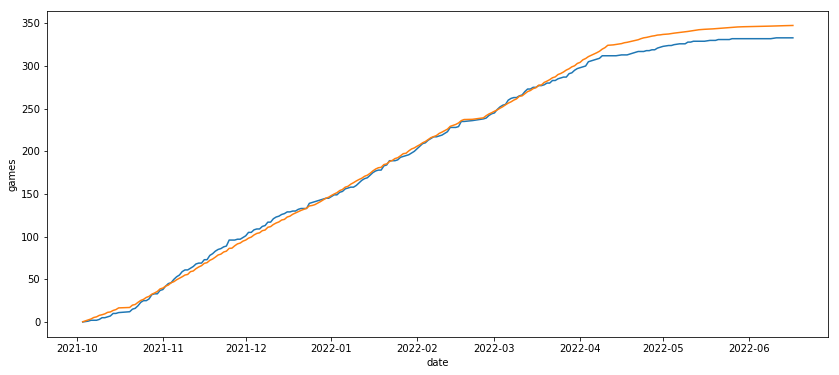

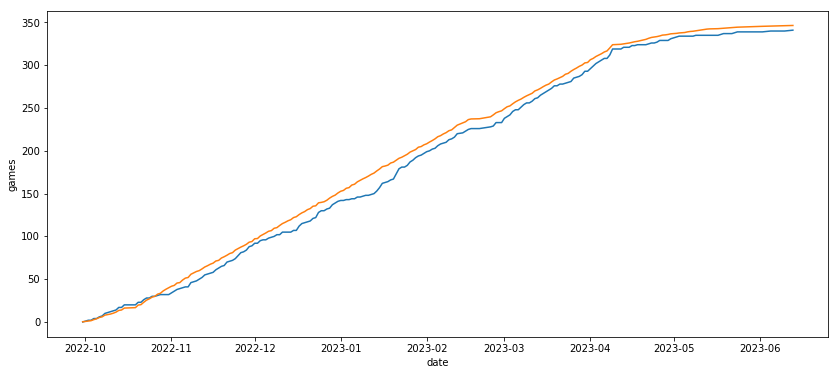

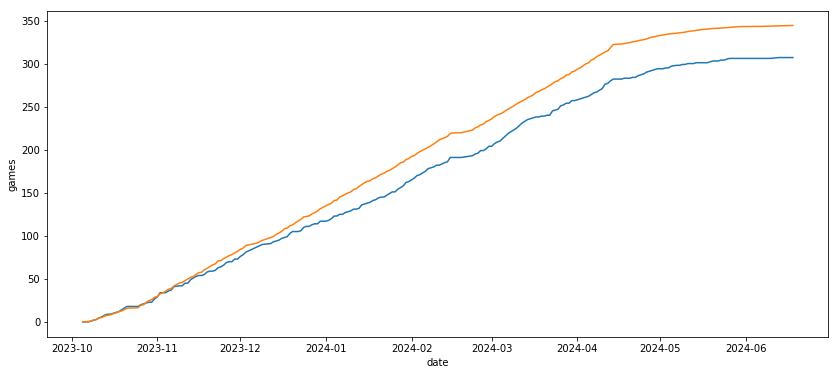

In [13]:
for df in dfs:
    chart = df.groupby('date').agg({'result':'sum'}).cumsum()

    chart['games_number'] = df.groupby('date').agg({'result':'count'}).cumsum()
    chart.reset_index(inplace=True)
    chart['quorter'] = chart['games_number'] / 4

    plt.figure(figsize=(14, 6))
    sns.lineplot(x=chart.date, y=chart.result, markers=True)
    sns.lineplot(x=chart.date, y=chart.quorter, markers=True)
    plt.ylabel('games')
    plt.show

Список с датами понадобится для визуализации и колонки со стадиями сезона: 1 - preseason, 2 - регулярный сезон до allstar game, 3 - регулярный сезон после allstar game, 4 - плейофф.

In [14]:
stages =[['2010-10-27','2011-02-21','2011-04-15'], ['2011-12-25','2012-02-27','2012-04-27'],
         ['2012-10-31','2013-02-18','2013-04-19'], ['2013-10-30','2014-02-17','2014-04-19'], 
         ['2014-10-29','2015-02-16','2015-04-18'], ['2015-10-28','2016-02-15','2016-04-16'],
         ['2016-10-26','2017-02-20','2017-04-15'], ['2017-10-18','2018-02-19','2018-04-14'],
         ['2018-10-17','2019-02-18','2019-04-13'], ['2021-10-20','2022-02-21','2022-04-13'], 
         ['2022-10-19','2023-02-20','2023-04-12'], ['2023-10-25','2024-02-19','2024-04-17']]

Сагрегируем процент результативных игр по неделям и выведем на график barplot. Не будем выводить на график недели с количеством игр меньше 10 (такие недели будут в начале и конце сезона) для минимализации дисперсии.
Горизонтальной зеленой линией отметим 25-й процент результативных игр для наглядности. Вертикальнми линиями отметим: 1-я линия - конец preaseson, начало регулярного сезона, 2-я линия - allstar game, 3-я линия - конец регулярного сезона начало плейоф.
Визуально заметно, что чаще всего бары стадии preaseason выше отметки 0.25, корреляции по другим стадиям не наблюдается.

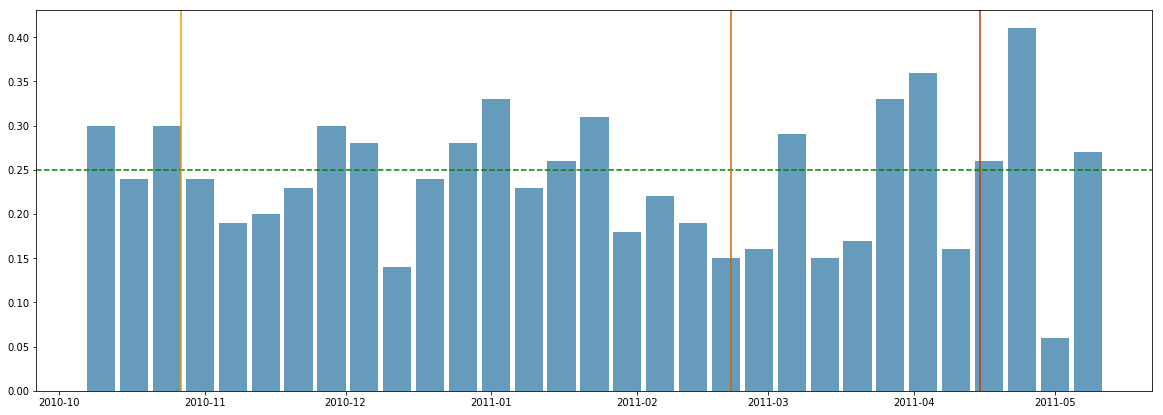

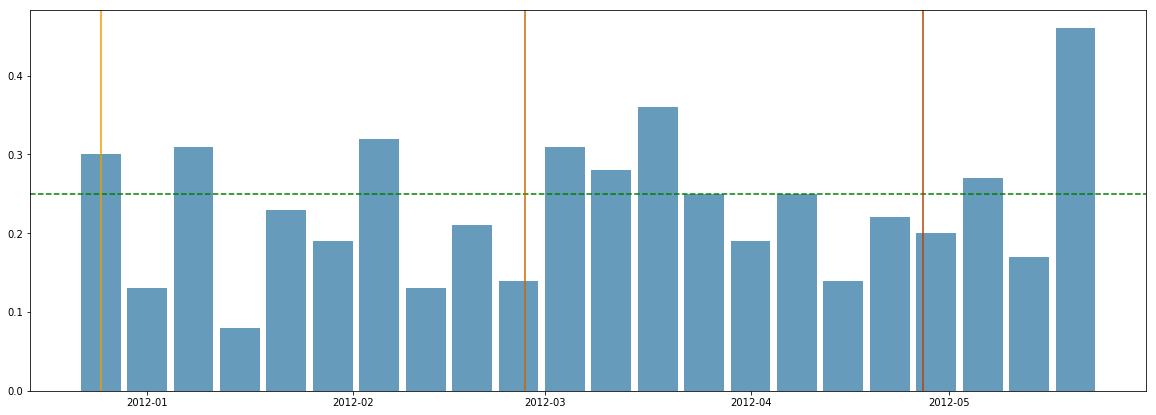

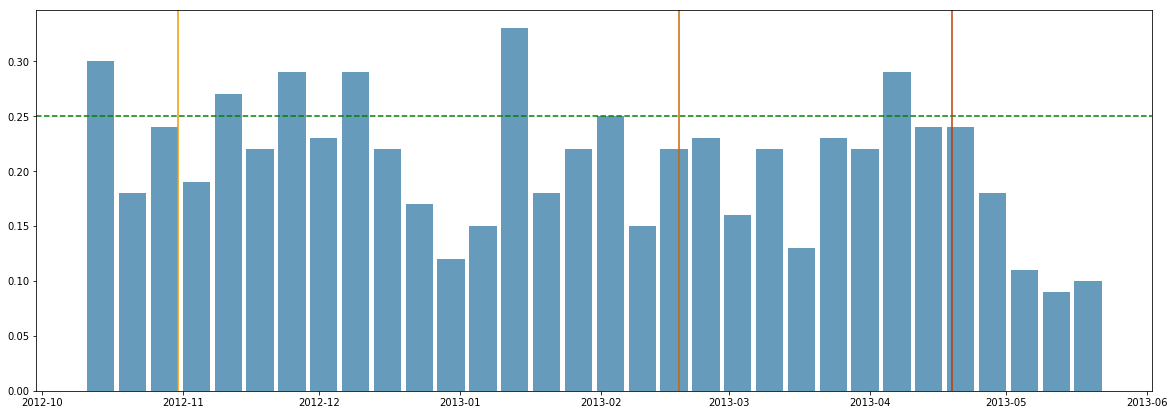

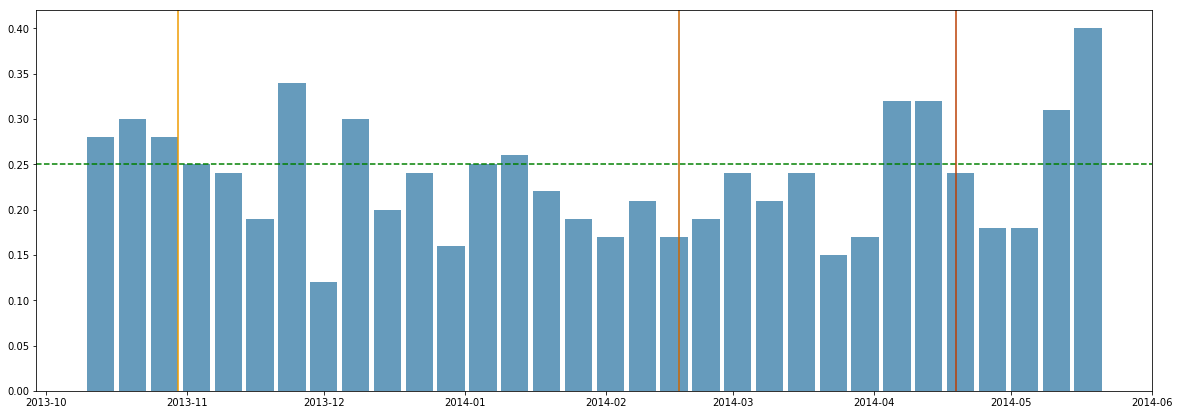

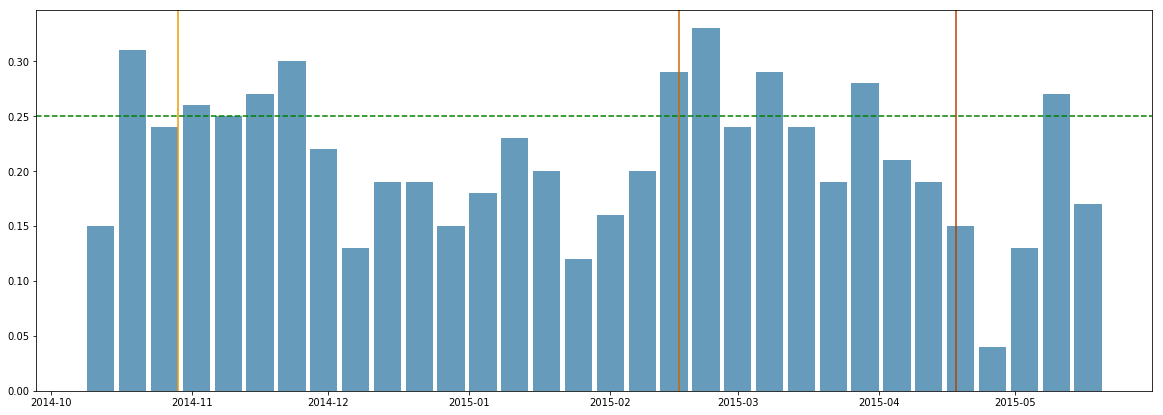

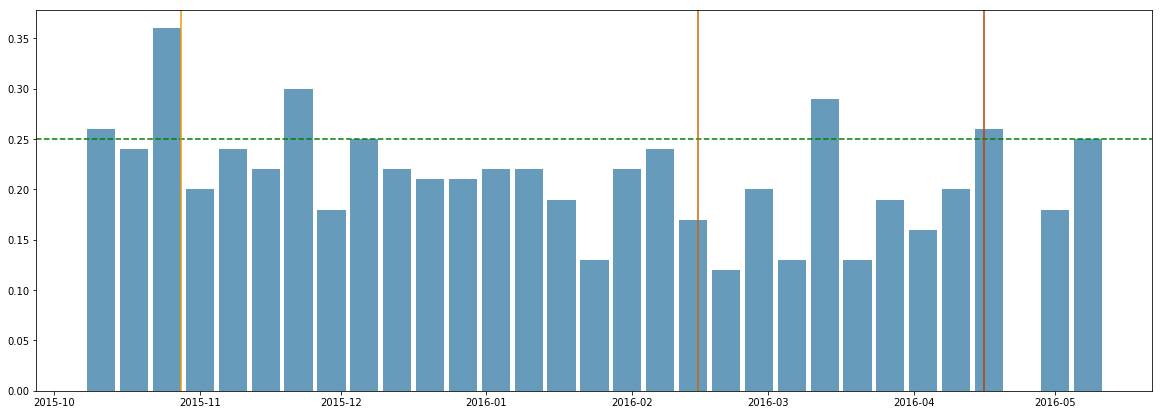

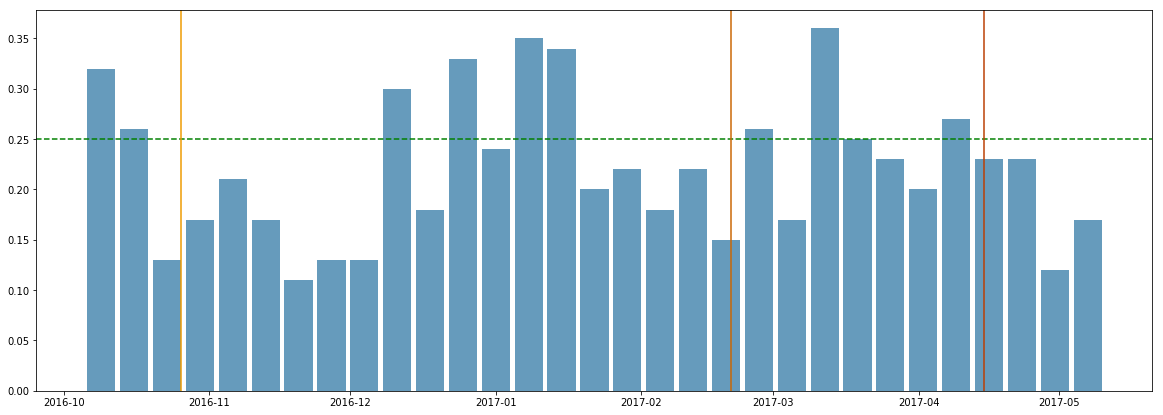

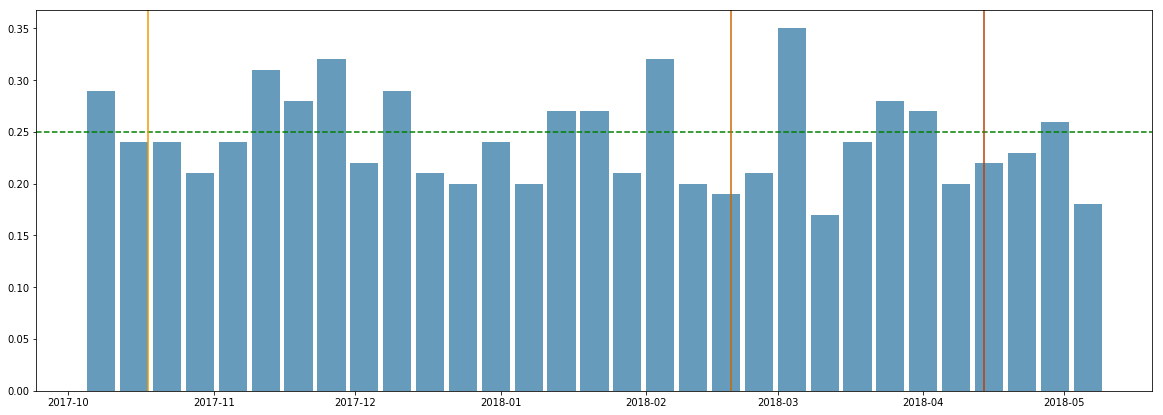

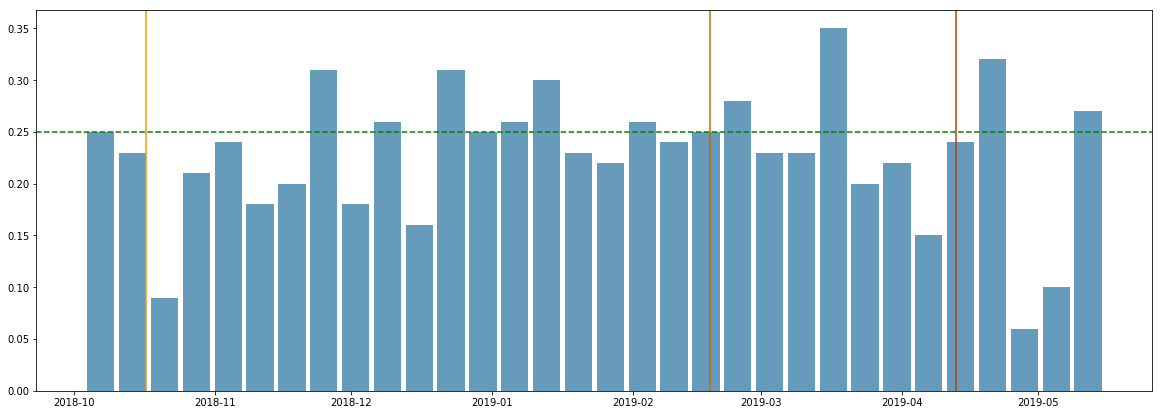

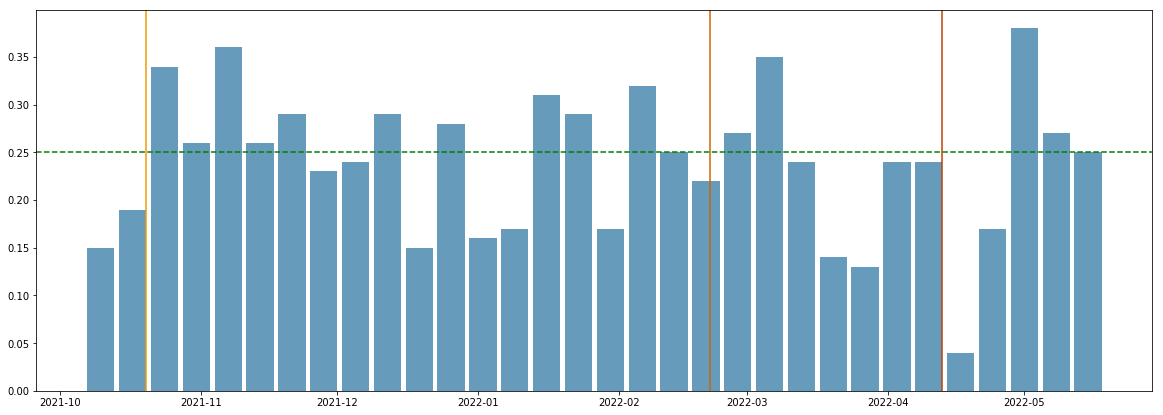

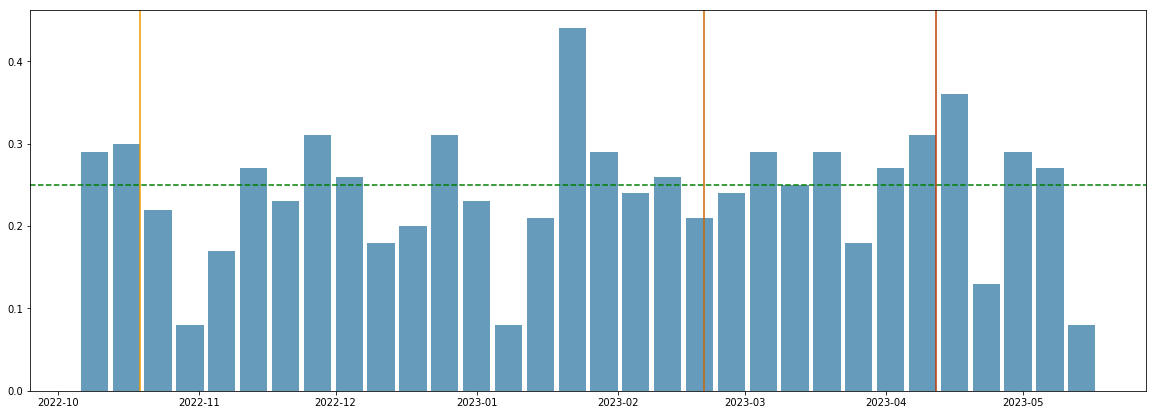

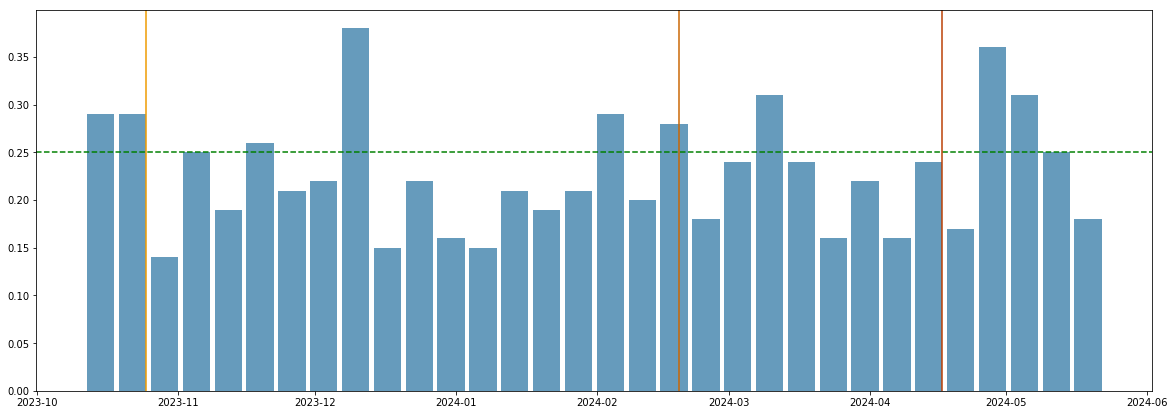

In [15]:
season_number = 0; 
for df in dfs: 
    week_chart = df.groupby(pd.Grouper(key='date', freq='W')).agg({'result':'sum'})
    week_chart['games_number'] = df.groupby(pd.Grouper(key='date', freq='W')).agg({'result':'count'})
    week_chart.reset_index(inplace=True)
    week_chart['share'] = (week_chart['result'] / week_chart['games_number']).round(2)
    
    week_chart = week_chart[week_chart['games_number'] >= 10]
    
    plt.figure(figsize=(20, 7))
    plt.bar(week_chart['date'], week_chart['share'], color='#669bbc', width=6)

    plt.axhline(y=0.25, color='green', linestyle='--')
          
    plt.axvline(x='{}'.format(stages[season_number][0]),color='#ee9b00')
    plt.axvline(x='{}'.format(stages[season_number][1]),color='#ca6702')
    plt.axvline(x='{}'.format(stages[season_number][2]),color='#bb3e03')
    
    # Adding stages to df-s:
    #                       1 - preaseason
    #                       2 - regular season before allstars game
    #                       3 - regular season after allstars game
    #                       4 - playoffs
    df.loc[(df['date'] < '{}'.format(stages[season_number][0])), 'stage'] = 1
    df.loc[(df['date'] >= '{}'.format(stages[season_number][0])), 'stage'] = 2
    df.loc[(df['date'] > '{}'.format(stages[season_number][1])), 'stage'] = 3
    df.loc[(df['date'] > '{}'.format(stages[season_number][2])), 'stage'] = 4
    df['stage'] = df['stage'].astype('int')
                
    plt.show()
    
    season_number += 1

Загрузим список наших датафреймов в фаил 'dataframes.pkl' для дальнейшей работы во второй части проекта.

In [16]:
import pickle
with open('dataframes.pkl', 'wb') as file:
    pickle.dump(dfs, file)